<a href="https://colab.research.google.com/github/NeuralNetGeek/my-ML-training/blob/main/Copy_of_Monkey_Pox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
cols=['Patient_ID', 'Systemic Illness', 'Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection', 'MonkeyPox']
df=pd.read_csv('monkey.data.csv').drop(['Patient_ID', 'Systemic Illness'],axis=1)
df.head(10)

,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,False,True,True,True,False,True,False,False,Negative
1,True,False,True,True,False,False,True,False,Positive
2,False,True,True,False,False,False,True,False,Positive
3,True,False,False,False,True,True,True,False,Positive
4,True,True,True,False,False,True,True,False,Positive
5,False,True,False,False,False,False,False,False,Negative
6,False,True,False,False,False,False,True,False,Positive
7,True,True,False,True,True,True,False,False,Positive
8,False,True,True,True,False,False,False,False,Positive
9,False,False,True,True,True,False,True,False,Negative


In [ ]:
encoder = LabelEncoder()
features = ['Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection']
for col in features:
    df[col + '_encoded'] = encoder.fit_transform(df[col])
for MonkeyPox in ['MonkeyPox']:
    df['MonkeyPox_encoded'] = encoder.fit_transform(df[MonkeyPox])

print(df)

       Rectal Pain  Sore Throat  Penile Oedema  Oral Lesions  Solitary Lesion  \
0            False         True           True          True            False   
1             True        False           True          True            False   
2            False         True           True         False            False   
3             True        False          False         False             True   
4             True         True           True         False            False   
...            ...          ...            ...           ...              ...   
24995         True         True          False          True             True   
24996        False         True           True         False             True   
24997         True         True          False         False             True   
24998        False         True          False          True             True   
24999        False        False           True         False            False   

       Swollen Tonsils  HIV

In [ ]:
features_encoded = [col + '_encoded' for col in features]
target = 'MonkeyPox_encoded'

X = df[features_encoded]
y = df[target]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X_train, y_train = smote_tomek.fit_resample(X_train, y_train)

In [ ]:
models = {"Logistic Regression": LogisticRegression(solver='saga', penalty='elasticnet', C=0.5, class_weight='balanced', max_iter=2000, l1_ratio=0), "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5), "Naive Bayes": GaussianNB(), "Support Vector Machine": SVC(probability=True, class_weight='balanced', random_state=42), "RandomForestClassifier": RandomForestClassifier(class_weight='balanced', random_state=42)}
for name, model in models.items():

    model.fit(X_train, y_train)

def evaluate_classifiers(models, X_test, y_test, show_reports=True):
    summary = []
    for name, model in models.items():
        try:
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            roc_auc = None
            if hasattr(model, "predict_proba"):
                try:
                    y_prob = model.predict_proba(X_test)[:, 1]

                    if len(np.unique(y_test)) > 1:
                         roc_auc = roc_auc_score(y_test, y_prob)
                    else:

                         roc_auc = np.nan
                         if show_reports:
                             print(f"Skipping ROC AUC calculation for {name}: Test set contains only one class.")

                except Exception as e:
                    if show_reports:
                        print(f"Could not calculate ROC AUC for {name}: {e}")


            summary.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc_auc if roc_auc is not None else np.nan
            })

            if show_reports:
                print(f"\n Model: {name}")
                print("Confusion Matrix:")
                print(confusion_matrix(y_test, y_pred))
                print("\nClassification Report:")
                print(classification_report(y_test, y_pred, zero_division=0))

        except ValueError as e:
            if show_reports:
                print(f"\n Could not evaluate {name} due to ValueError: {e}")
            summary.append({
                'Model': name,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1 Score': np.nan,
                'ROC-AUC': np.nan
            })
        except Exception as e:
            if show_reports:
                print(f"\n An unexpected error occurred while evaluating {name}: {e}")
            summary.append({
                'Model': name,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1 Score': np.nan,
                'ROC-AUC': np.nan
            })


    return pd.DataFrame(summary)


 Model: Logistic Regression
Confusion Matrix:
[[1111  707]
 [1215 1967]]

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.61      0.54      1818
           1       0.74      0.62      0.67      3182

    accuracy                           0.62      5000
   macro avg       0.61      0.61      0.60      5000
weighted avg       0.64      0.62      0.62      5000


 Model: K-Nearest Neighbors
Confusion Matrix:
[[ 705 1113]
 [ 817 2365]]

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.39      0.42      1818
           1       0.68      0.74      0.71      3182

    accuracy                           0.61      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.60      0.61      0.61      5000


 Model: Naive Bayes
Confusion Matrix:
[[1107  711]
 [1199 1983]]

Classification Report:
              precision    recall  f1-score   support

     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


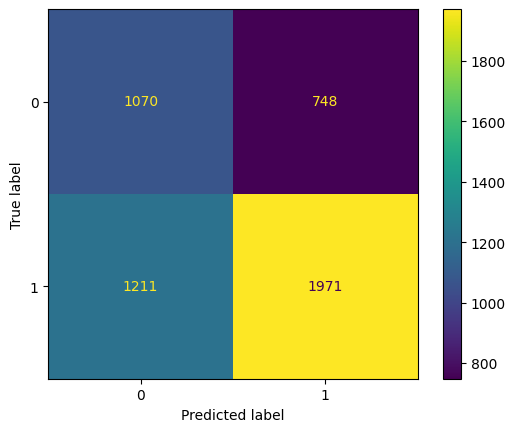

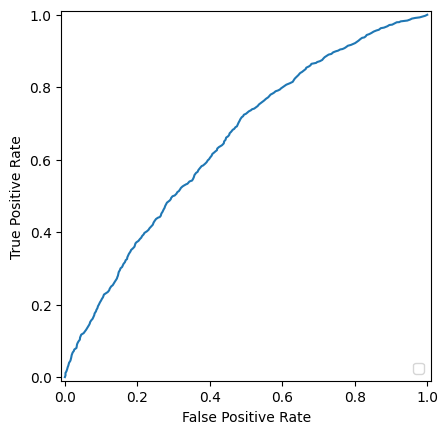

In [ ]:
results = evaluate_classifiers(models, X_test, y_test)
print("\n Model Comparison Summary:")
print(results)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()